# **Import Libraries**

In [1]:
!pip install shap
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve


import shap
import warnings
warnings.filterwarnings("ignore")

# **Load the Dataset**




In [3]:
train = pd.read_csv('/content/train_project.csv')
test = pd.read_csv('/content/test_project.csv')
test_ids = test['PassengerId']

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
train.isnull().sum()

,0
PassengerId,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208


# **Preprocessing**

# **`Cabin Feature Engineering`**

In [8]:
for df in [train, test]:
    df[['Deck','CabinNum','Side']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    df['TotalExpenses'] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

# **`Handle Missing Value`**

In [9]:
cols_cat = ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side']
cols_num = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','CabinNum']

for df in [train, test]:
    for c in cols_cat:
        df[c].fillna(df[c].mode()[0], inplace=True)
    for c in cols_num:
        df[c].fillna(df[c].median(), inplace=True)

In [10]:
for df in [train, test]:
    df['Cabin'].fillna('Unknown/Unknown/0', inplace=True)
    df['Name'].fillna('Unknown', inplace=True)


In [11]:
train.isnull().sum()

,0
PassengerId,0
HomePlanet,0
CryoSleep,0
Cabin,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0


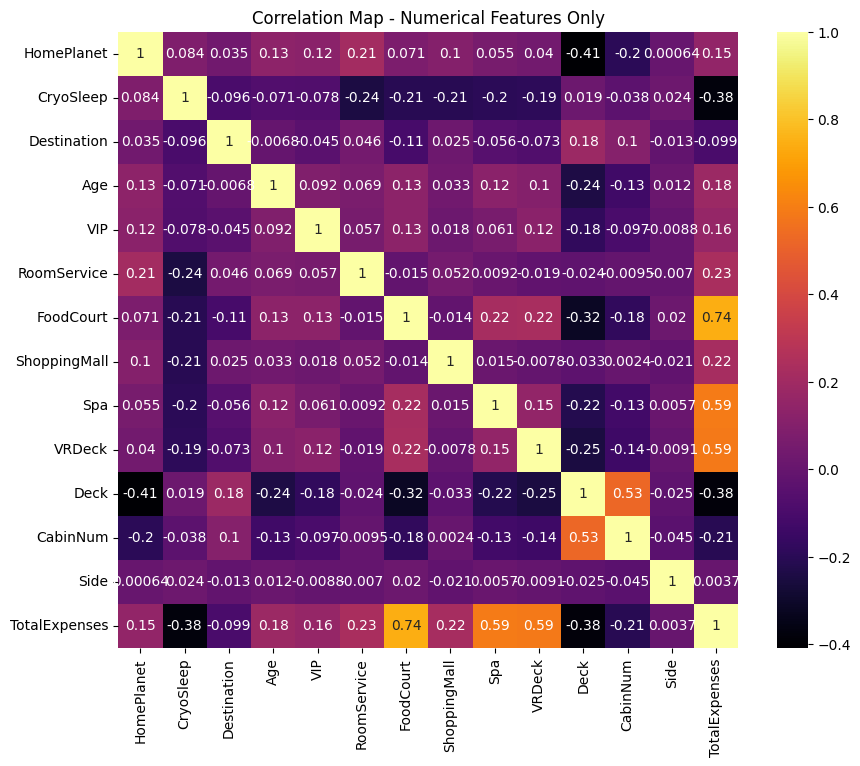

In [32]:
# heatmap

numeric_cols = train.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='inferno')
plt.title("Correlation Map - Numerical Features Only")
plt.show()

# **`Encoding & Scaling`**

In [12]:
le = LabelEncoder()
for c in cols_cat:
    train[c] = le.fit_transform(train[c].astype(str))
    test[c] = le.transform(test[c].astype(str))

scaler = StandardScaler()
train[cols_num + ['TotalExpenses']] = scaler.fit_transform(train[cols_num + ['TotalExpenses']])
test[cols_num + ['TotalExpenses']] = scaler.transform(test[cols_num + ['TotalExpenses']])

# **Modeling**

# **`Feature Selection & Target Variable Definition`**

In [13]:
X = train.drop(['PassengerId','Name','Cabin','Transported'], axis=1)
y = train['Transported'].astype(int)
X_test = test.drop(['PassengerId','Name','Cabin'], axis=1)

# **`Dimensionality Reduction using PCA`**

In [14]:
pca_n_components = min(10, X.shape[1])
pca_transformer = PCA(n_components=pca_n_components)
X_pca = pca_transformer.fit_transform(X)
X_test_pca = pca_transformer.transform(X_test)

# **`XGBoost`**

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'lambda': [0.1, 1, 5],
    'alpha': [0, 0.1, 0.5]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_random_search = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=30, cv=skf,
                                       scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)

xgb_random_search.fit(X, y)

print(f"Best XGBoost parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost accuracy: {xgb_random_search.best_score_:.4f}")

best_xgb_model = xgb_random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGBoost parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 0.1}
Best XGBoost accuracy: 0.8119


# **`CatBoost Classifier`**

In [16]:
catboost_params = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.03, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_search = RandomizedSearchCV(cat_model, catboost_params, n_iter=30, cv=skf, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
cat_search.fit(X, y)

print("Best CatBoost parameters:", cat_search.best_params_)
print(f"Best CatBoost accuracy: {cat_search.best_score_:.4f}")
best_cat_model = cat_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CatBoost parameters: {'learning_rate': 0.03, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6}
Best CatBoost accuracy: 0.8156


# **`Random Forest Classifier`**

In [17]:
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf_model, rf_param_grid, n_iter=30, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
rf_search.fit(X, y)

print("Best Random Forest parameters:", rf_search.best_params_)
print(f"Best Random Forest accuracy: {rf_search.best_score_:.4f}")
best_rf_model = rf_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': True}
Best Random Forest accuracy: 0.8073


# **`Model Performance`**

In [18]:
y_pred_xgb_train = best_xgb_model.predict(X)
y_pred_cat_train = best_cat_model.predict(X)
y_pred_rf_train = best_rf_model.predict(X)

print("----- Model Accuracies -----\n")

print("XGBoost:")
print(f" - Cross-Validation Accuracy: {xgb_random_search.best_score_:.4f}")
print(f" - Training Accuracy : {accuracy_score(y, y_pred_xgb_train):.4f}")

print("\n CatBoost:")
print(f" - Cross-Validation Accuracy: {cat_search.best_score_:.4f}")
print(f" - Training Accuracy : {accuracy_score(y, y_pred_cat_train):.4f}")

print("\n Random Forest:")
print(f" - Cross-Validation Accuracy: {rf_search.best_score_:.4f}")
print(f" - Training Accuracy : {accuracy_score(y, y_pred_rf_train):.4f}")

----- Model Accuracies -----

XGBoost:
 - Cross-Validation Accuracy: 0.8119
 - Training Accuracy : 0.8674

 CatBoost:
 - Cross-Validation Accuracy: 0.8156
 - Training Accuracy : 0.8471

 Random Forest:
 - Cross-Validation Accuracy: 0.8073
 - Training Accuracy : 0.9018


# **`CatBoost Classification Report & Confusion Matrix`**

Classification Report (CatBoost):

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      4315
           1       0.84      0.87      0.85      4378

    accuracy                           0.85      8693
   macro avg       0.85      0.85      0.85      8693
weighted avg       0.85      0.85      0.85      8693



<Figure size 600x600 with 0 Axes>

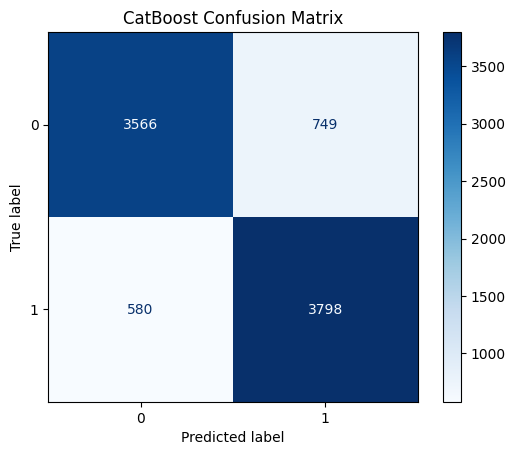

In [19]:
y_pred_cat = best_cat_model.predict(X)

print("Classification Report (CatBoost):\n")
print(classification_report(y, y_pred_cat))

cm = confusion_matrix(y, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_cat_model.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("CatBoost Confusion Matrix")
plt.show()


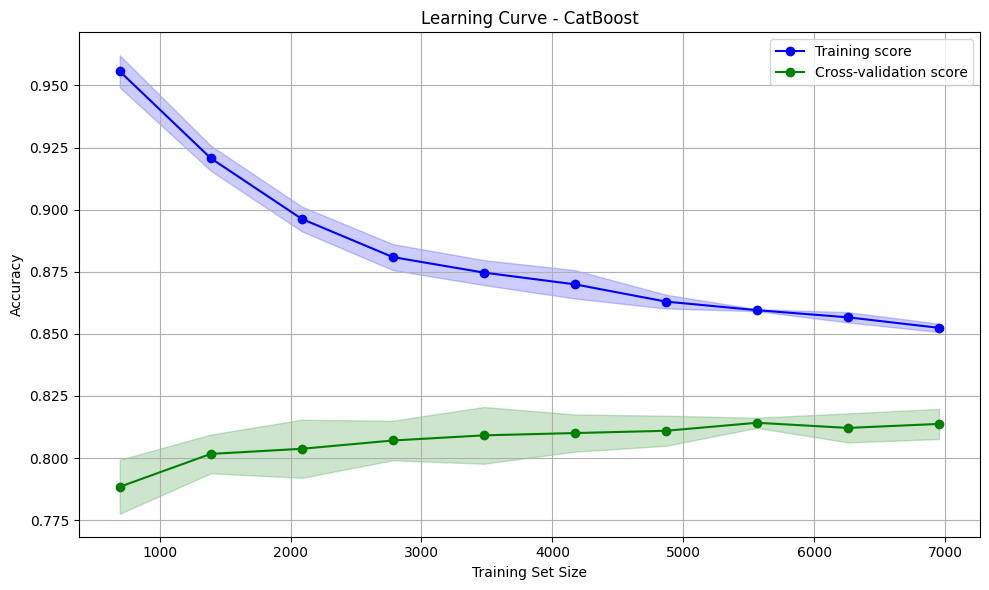

In [29]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_cat_model, X, y,
    cv=skf,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="blue")

plt.plot(train_sizes, val_scores_mean, 'o-', color="green", label="Cross-validation score")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color="green")

plt.title("Learning Curve - CatBoost")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

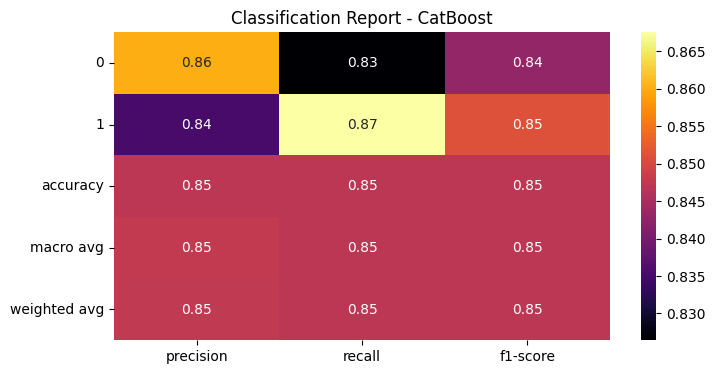

In [28]:
report_dict = classification_report(y, y_pred_cat, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

#plot_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:, :-1], annot=True, fmt=".2f", cmap="inferno")
plt.title("Classification Report - CatBoost")
plt.yticks(rotation=0)
plt.show()

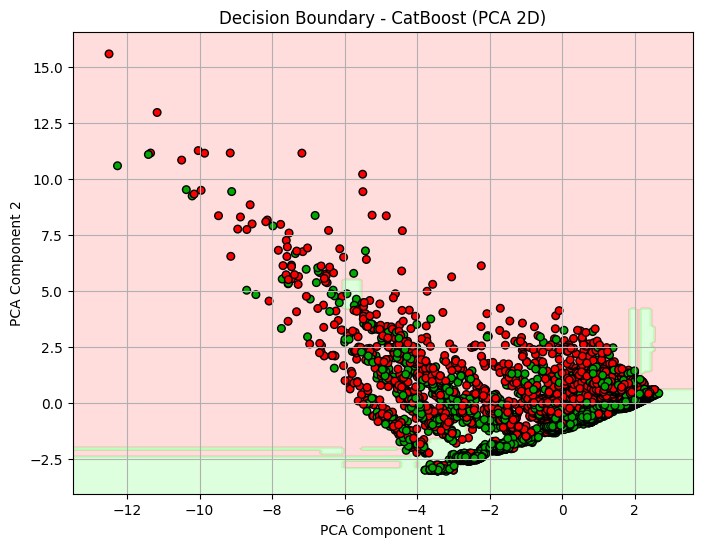

In [30]:
from matplotlib.colors import ListedColormap

X_pca_2d = PCA(n_components=2).fit_transform(X)

best_cat_model.fit(X_pca_2d, y)

x_min, x_max = X_pca_2d[:, 0].min() - 1, X_pca_2d[:, 0].max() + 1
y_min, y_max = X_pca_2d[:, 1].min() - 1, X_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = best_cat_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00AA00'])

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=30)
plt.title("Decision Boundary - CatBoost (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

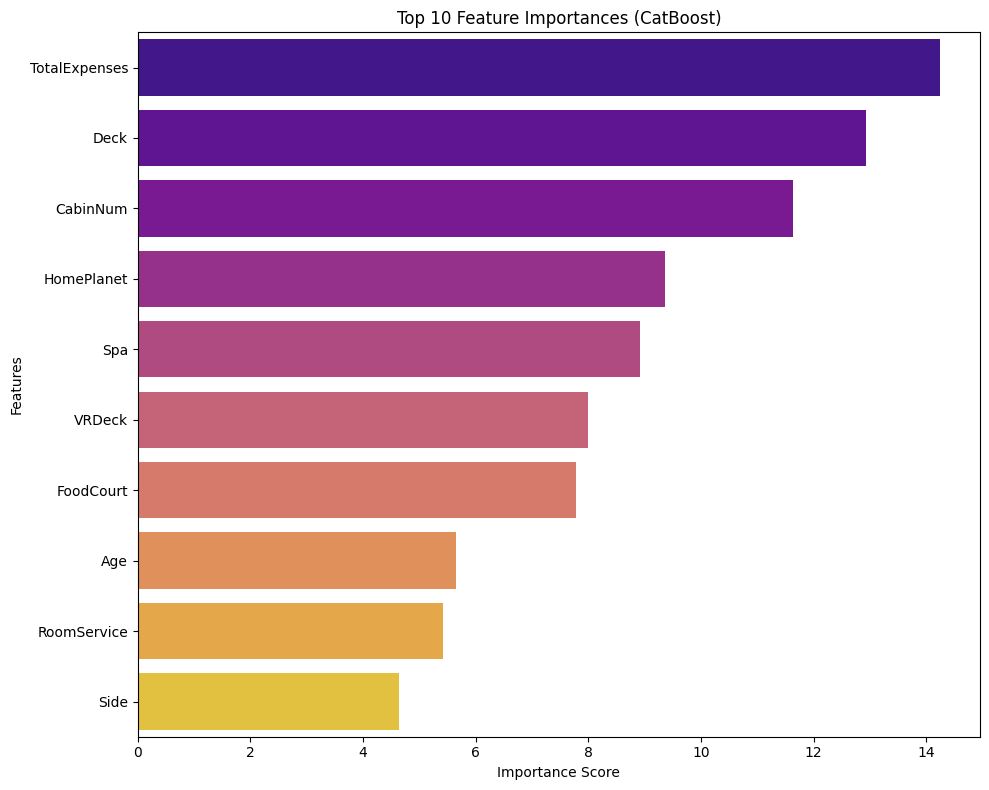

In [36]:
best_cat_modell = CatBoostClassifier(verbose=0, random_state=42)
best_cat_modell.fit(X, y)

importances = best_cat_modell.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='plasma')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# **Final Submission File**

In [20]:
final_model = best_cat_model

predictions = final_model.predict(X_test)

submission_df = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': predictions.astype(bool)
})

submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully!")


Submission file 'submission.csv' created successfully!
